In [1]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# df = pd.concat([pd.read_csv("results_all.csv"), pd.read_csv("results_all_2.csv")]).iloc[:,1:].drop_duplicates()
df = pd.concat([pd.read_csv("results_0_250_20200218.csv"), pd.read_csv("results_250_431_20200218.csv")]).iloc[:,1:].drop_duplicates()
## Only takes approved and rejected websites
df = df[df.label.isin(['APPROVED', 'REJECTED'])]

In [3]:
## Comment the code below if you want anomaly to be included
df = df[~(((df.broken_link_score == 100) & (df.label == 'APPROVED')) | \
          ((df['link_tnc_exist'] == 0) & (df['tnc_refund_policy_exist'] == 0))) | (df.label == 'REJECTED')]

In [4]:
df.groupby("label").size()

label
APPROVED    174
REJECTED     24
dtype: int64

In [5]:
y = df['label'].apply(lambda x: 1 if x == 'APPROVED' else 0)

In [6]:
X = df.iloc[:, 1:10]

In [7]:
X = X.drop(['contact_us_score', 'tnc_score', 'broken_link_score'], axis=1)

## Train/Test Split

In [32]:
X.columns

Index(['link_contact_us_exist', 'cu_email_exist', 'cu_phone_number_exist',
       'link_about_us_exist', 'link_tnc_exist', 'tnc_refund_policy_exist'],
      dtype='object')

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [34]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [35]:
y_pred = clf.predict(X_test)

In [36]:
y_pred_proba = clf.predict_proba(X_test)

In [37]:
accuracy_score(y_test, y_pred)

0.9393939393939394

In [38]:
y_test.value_counts()

1    56
0    10
Name: label, dtype: int64

In [39]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(8, 2, 2, 54)

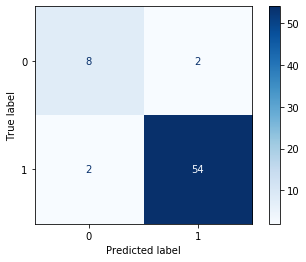

In [40]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [42]:
auc_score = auc(fpr, tpr)

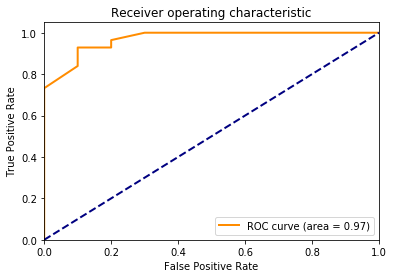

In [54]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [55]:
gini_score = abs(2 * auc_score) - 1
gini_score

0.9392857142857141

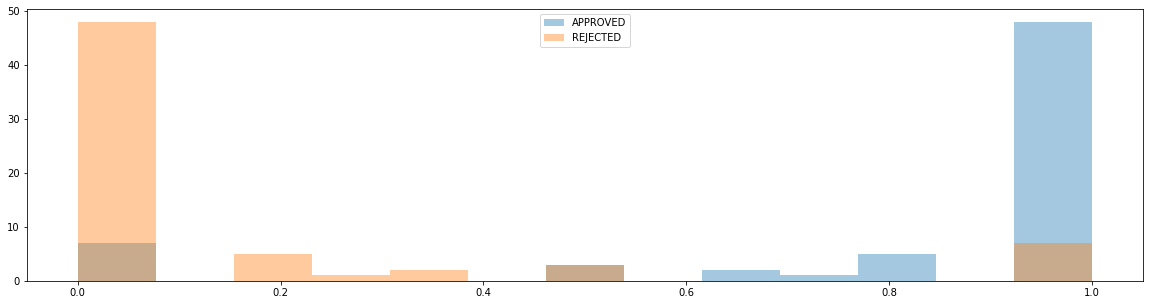

In [56]:
plt.figure(figsize=(20,5))
sns.distplot(y_pred_proba[:,1], kde=False, label='APPROVED')
sns.distplot(y_pred_proba[:,0], kde=False, label='REJECTED')
plt.legend()
plt.show()

## Cross Validation

In [57]:
clf = tree.DecisionTreeClassifier()

In [66]:
cv_results = cross_validate(clf, X, y, scoring='roc_auc', cv=4)

In [67]:
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_score']

In [68]:
cv_results['test_score']

array([0.99431818, 1.        , 0.93023256, 0.75968992])

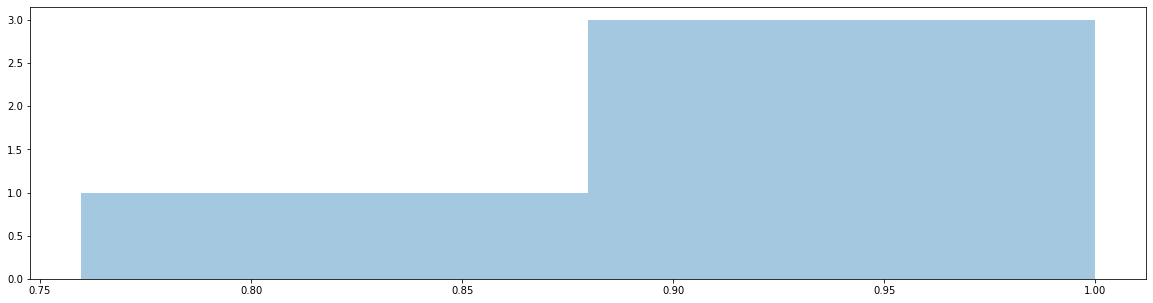

In [69]:
plt.figure(figsize=(20,5))
sns.distplot(cv_results['test_score'], kde=False)
plt.show()